# Analýza uživatelů ecommerce pro doporučování produktů
#### Autor: Matěj Foukal

## Původ a struktura dat
Data byla nashromážděna v průběhu 2 měsíců zakladateli startupové společnosti. Byla shromážděna pro účely výzkumu a implementace personalizačních strategií v ecommerce. Celý dataset je veřejně dostupný na stránkách [kaggle.com](https://www.kaggle.com/datasets/kartikeybartwal/ecommerce-product-recommendation-collaborative/data). Na datech si vyzkoušíme různé techniky vizualizace dat, testování hypotéz a lineární regresi.

In [16]:
# Naimportujeme potřebné knihovny
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
from scipy import stats
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split

## Příprava dat a deskriptivní statistiky proměnných
Pro lepší porozumění dat, která máme k dispozici, je nejprve popíšeme pomocí statistik dostupných proměnných. Pro lepší porozumění toho, kdo jsou naši uživatelé, vizualizujeme jejich demografické údaje. Podíváme se na souvislost mezi věkem a příjmy našich uživatelů.

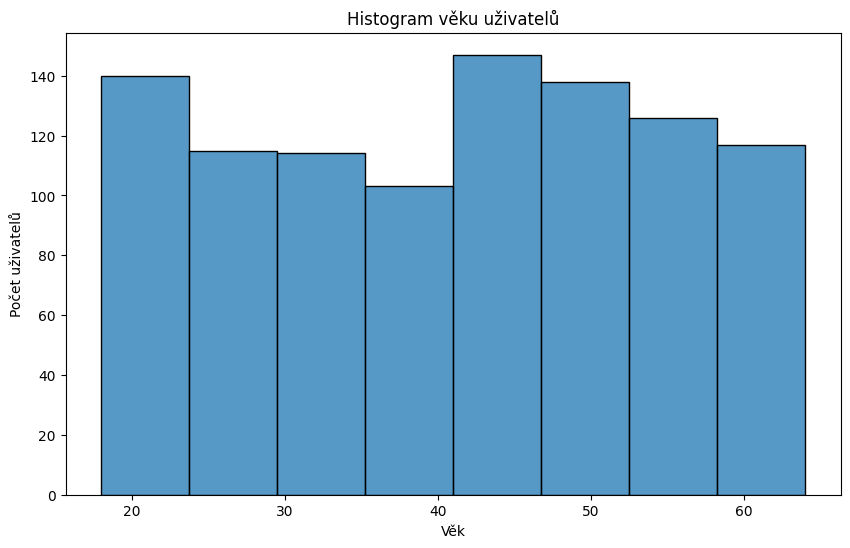

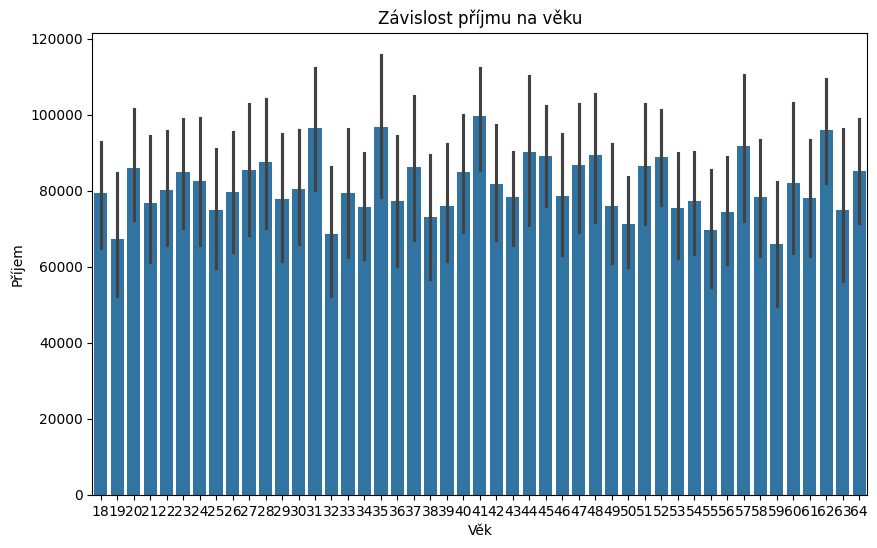

In [17]:
# Načtení dat
data = pd.read_csv("user_personalized_features.csv")

# Zobrazení dat pro věk uživatelů - klasický histogram s 8 biny
plt.figure(figsize=(10, 6))
sns.histplot(data["Age"], bins=8, kde=False)
plt.title("Histogram věku uživatelů")
plt.xlabel("Věk")
plt.ylabel("Počet uživatelů")
plt.show()

# Závislost příjmu na věku - scatter plot
plt.figure(figsize=(10, 6))
sns.barplot(x="Age", y="Income", data=data)
plt.title("Závislost příjmu na věku")
plt.xlabel("Věk")
plt.ylabel("Příjem")
plt.show()

## Korelace
1. Zjistíme, zda uživatelé, kteří nakupují častěji (Purchase_Frequency), mají nižší nebo vyšší průměrnou hodnotu objednávky (Average_Order_Value).
2. Zjistíme, zda vyšší příjem (Income) souvisí s vyššími celkovými výdaji (Total_Spending).

Korelace mezi frekvencí nákupů a průměrnou hodnotou objednávky: -0.03 (p-hodnota: 3.68e-01)


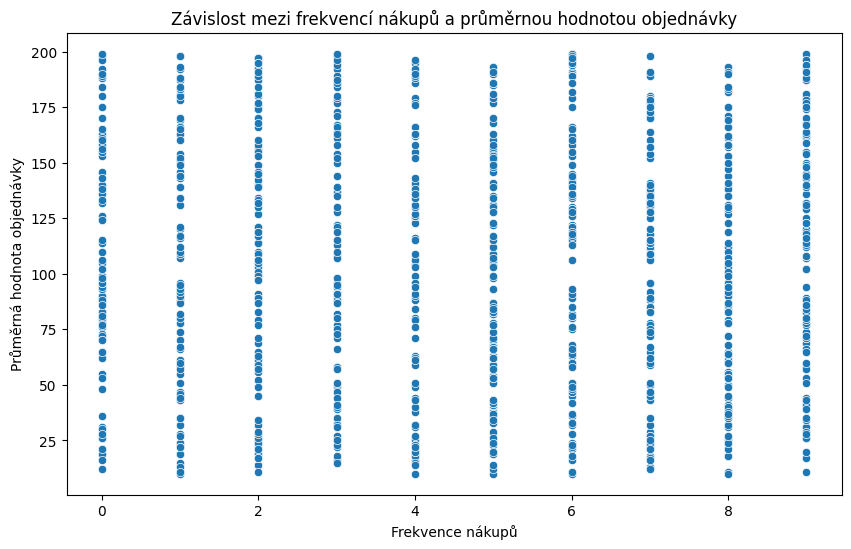

Korelace mezi příjmem a celkovými výdaji: -0.08 (p-hodnota: 7.49e-03)


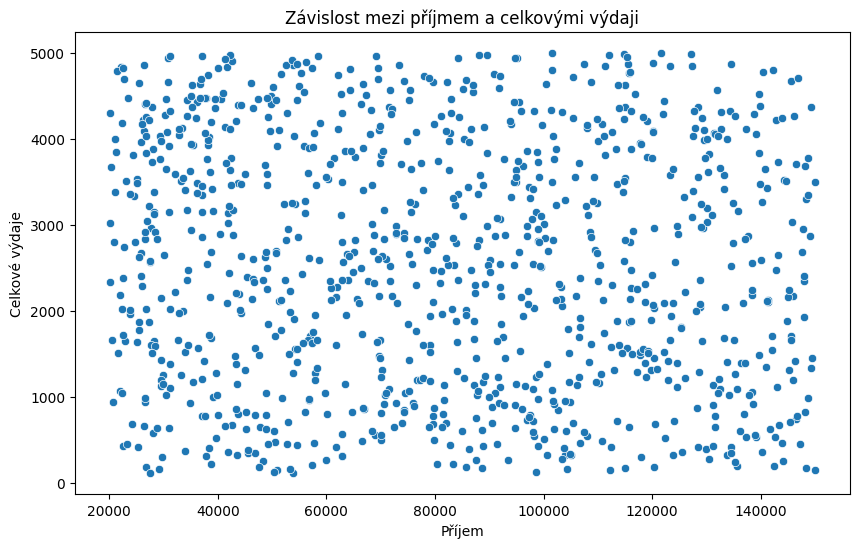

In [18]:
# 1. Korelace mezi frekvencí nákupů a průměrnou hodnotou objednávky
corr_freq_order_value, p_value_freq_order_value = stats.pearsonr(
    data["Purchase_Frequency"], data["Average_Order_Value"]
)
print(
    f"Korelace mezi frekvencí nákupů a průměrnou hodnotou objednávky: {corr_freq_order_value:.2f} (p-hodnota: {p_value_freq_order_value:.2e})"
)

# Vizualizace závislosti
plt.figure(figsize=(10, 6))
sns.scatterplot(x="Purchase_Frequency", y="Average_Order_Value", data=data)
plt.title("Závislost mezi frekvencí nákupů a průměrnou hodnotou objednávky")
plt.xlabel("Frekvence nákupů")
plt.ylabel("Průměrná hodnota objednávky")
plt.show()

# 2. Korelace mezi příjmem a celkovými výdaji
corr_income_spending, p_value_income_spending = stats.pearsonr(
    data["Income"], data["Total_Spending"]
)
print(
    f"Korelace mezi příjmem a celkovými výdaji: {corr_income_spending:.2f} (p-hodnota: {p_value_income_spending:.2e})"
)

# Vizualizace závislosti
plt.figure(figsize=(10, 6))
sns.scatterplot(x="Income", y="Total_Spending", data=data)
plt.title("Závislost mezi příjmem a celkovými výdaji")
plt.xlabel("Příjem")
plt.ylabel("Celkové výdaje")
plt.show()

## Testování hypotéz
Otestujeme následující tři hypotézy:
1. Vliv lokality uživatelů (suburban, rural, urban) na hodnotu objednávky:
   - Null hypothesis (H0): Průměrná hodnota objednávky je stejná pro všechny tři lokality.
   - Alternative hypothesis (H1): Průměrná hodnota objednávky se liší mezi lokalitami.
2. Vliv zájmů na frekvenci nákupů:
   - Null hypothesis (H0): Zájmy uživatelů nemají vliv na frekvenci nákupů.
   - Alternative hypothesis (H1): Zájmy uživatelů mají vliv na frekvenci nákupů.

ANOVA: F-statistic = nan, p-value = nan


C:\Users\matfo\AppData\Local\Temp\ipykernel_13740\3689935461.py:2: SmallSampleWarning: One or more sample arguments is too small; all returned values will be NaN. See documentation for sample size requirements.
  anova_result = stats.f_oneway(


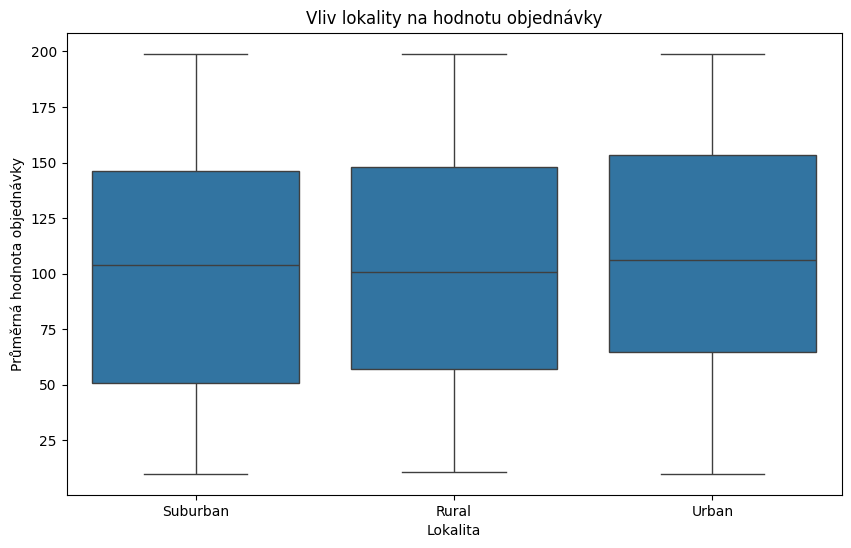

In [19]:
# ANOVA test pro vliv lokality na hodnotu objednávky
anova_result = stats.f_oneway(
    data[data["Location"] == "suburban"]["Average_Order_Value"],
    data[data["Location"] == "rural"]["Average_Order_Value"],
    data[data["Location"] == "urban"]["Average_Order_Value"],
)

print(
    f"ANOVA: F-statistic = {anova_result.statistic}, p-value = {anova_result.pvalue:.4f}"
)

# Vizualizace
plt.figure(figsize=(10, 6))
sns.boxplot(x="Location", y="Average_Order_Value", data=data)
plt.title("Vliv lokality na hodnotu objednávky")
plt.xlabel("Lokalita")
plt.ylabel("Průměrná hodnota objednávky")
plt.show()

Interest: Fashion - ANOVA: F-statistic = 1.6518, p-value = 0.1990
Interest: Food - ANOVA: F-statistic = 0.1196, p-value = 0.7296
Interest: Sports - ANOVA: F-statistic = 0.0003, p-value = 0.9870
Interest: Technology - ANOVA: F-statistic = 5.3560, p-value = 0.0209
Interest: Travel - ANOVA: F-statistic = 1.7180, p-value = 0.1902


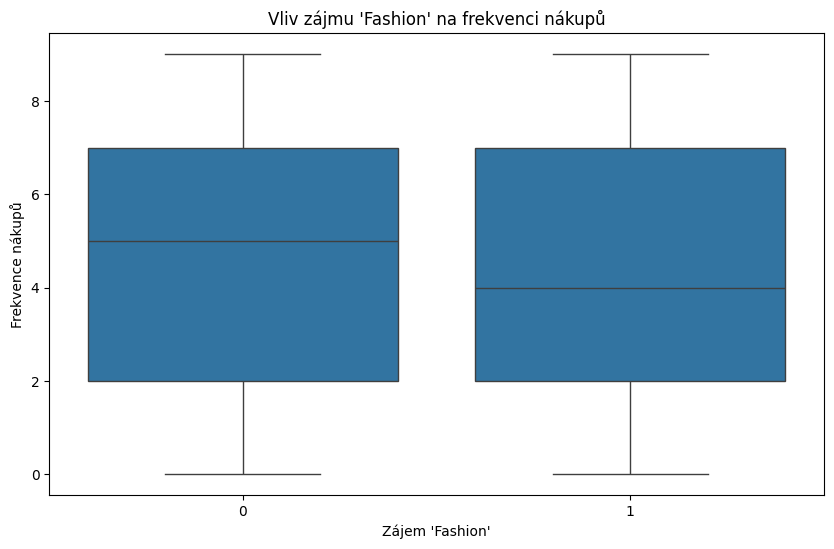

In [20]:
# Vytvoření binárních proměnných pro zájmy
interests_dummies = data["Interests"].str.get_dummies(sep=",")

# Přidáme frekvenci nákupů k binárním proměnným
interests_dummies["Purchase_Frequency"] = data["Purchase_Frequency"]

# Testování hypotézy pro každý zájem
for interest in interests_dummies.columns[:-1]:
    # Rozdělení dat podle zájmu
    freq_with_interest = interests_dummies[interests_dummies[interest] == 1][
        "Purchase_Frequency"
    ]
    freq_without_interest = interests_dummies[interests_dummies[interest] == 0][
        "Purchase_Frequency"
    ]

    # ANOVA test pro zájem
    anova_interest_result = stats.f_oneway(freq_with_interest, freq_without_interest)

    print(
        f"Interest: {interest} - ANOVA: F-statistic = {anova_interest_result.statistic:.4f}, p-value = {anova_interest_result.pvalue:.4f}"
    )

# Vizualizace pro první zájem (pouze jako příklad)
first_interest = interests_dummies.columns[0]
plt.figure(figsize=(10, 6))
sns.boxplot(
    x=interests_dummies[first_interest], y=interests_dummies["Purchase_Frequency"]
)
plt.title(f"Vliv zájmu '{first_interest}' na frekvenci nákupů")
plt.xlabel(f"Zájem '{first_interest}'")
plt.ylabel("Frekvence nákupů")
plt.show()

## Lineární regrese



## Interpretace výsledků a jejich zužitkování